### Importing dependencies

In [1]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fast")
import seaborn as sns
import missingno as msno
import pickle

# For data processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OrdinalEncoder,PowerTransformer,MinMaxScaler)
from sklearn.impute import KNNImputer
import category_encoders as ce
from imblearn.over_sampling import ADASYN

# For model training
from pycaret.classification import *
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna

# Chossing a style ( can see the list using the code : plt.style.available
plt.style.use("default")
print("Everything imported successfully")

Everything imported successfully


If facing some problem to load the csv file then checkout [this resource](https://www.shanelynn.ie/pandas-csv-error-error-tokenizing-data-c-error-eof-inside-string-starting-at-line/)

In [2]:
# Loading csv file
df = pd.read_csv("DataScientist.csv")

# Introductory EDA

In [3]:
# Checking the shape of the dataframe
print("Shape of the dataframe :", df.shape)

Shape of the dataframe : (3909, 17)


In [4]:
# Checking any 3 random rows
df.sample(3)

,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
1915,1915,2121,Senior Scientist-UV Coatings,$68K-$89K (Glassdoor est.),Company Overview\n\nKeystone Industries is a g...,3.4,Keystone Industries\n3.4,"Cherry Hill, NJ","Gibbstown, NJ",201 to 500 employees,-1,Company - Private,Health Care Products Manufacturing,Manufacturing,Unknown / Non-Applicable,-1,-1
3200,3200,3532,Data Engineer,$102K-$179K (Glassdoor est.),Responsibilities Develop and maintain scalable...,3.0,Sonus Software Solutions Inc.\n3.0,"Sunnyvale, CA","Orem, UT",Unknown,-1,Company - Private,-1,-1,Unknown / Non-Applicable,-1,-1
618,618,719,Planetary Data Engineer,$37K-$75K (Glassdoor est.),Job Details\n\nJob ID: 12030\n\nNew ideas are ...,4.3,Nasa Jet Propulsion Laboratory\n4.3,"Pasadena, CA","Pasadena, CA",5001 to 10000 employees,1936,Nonprofit Organization,Federal Agencies,Government,Unknown / Non-Applicable,-1,-1


In [5]:
# Replacing all the -1 values with nan
for col in ['Rating','Founded']:
  df[col] = df[col].replace(-1, np.nan)

for col in df.select_dtypes(include=object):
  df[col] = df[col].replace('-1', np.nan)

In [6]:
str1 = '$138K-$217K (Glassdoor est.)'
str1.split()[0].replace('$','').replace('-','').split('K')

['138', '217', '']

In [7]:
str2 = '$200K-$250K(Employer est.)'
str2.split('(')[0].replace('$','').replace('K','').split('-')

['200', '250']

In [8]:
# Removing rupee and , character from the 'price' feature and converting to int
for index in range(len(df)):
    item = df.loc[index, 'Salary Estimate']

    if (type(item) == float) or (type(item) == int):
      df.loc[index, 'Salary Estimate'] = int(item)

    else:

      if len(item.split()) == 4: # Per hour value is given
        df.loc[index, 'Salary Estimate'] = np.nan

      elif len(item.split()) == 3:
        lower_val = int(item.split()[0].replace('$','').replace('-','').split('K')[0])
        Upper_val = int(item.split()[0].replace('$','').replace('-','').split('K')[1])
        df.loc[index, 'Salary Estimate'] = (lower_val+Upper_val)/2

      elif len(item.split()) == 2:
        lower_val = int(item.split('(')[0].replace('$','').replace('K','').split('-')[0])
        Upper_val = int(int(item.split('(')[0].replace('$','').replace('K','').split('-')[1]))
        df.loc[index, 'Salary Estimate'] = (lower_val+Upper_val)/2

df.rename(columns={'Salary Estimate': 'Average Salary(K$)'}, inplace=True)
df['Average Salary(K$)'] = df['Average Salary(K$)'].astype(np.float64)

In [9]:
for i in range(len(df)):
    item_location = df.loc[i,'Location']
    item_hq = df.loc[i,'Headquarters']
    item_comp = df.loc[i,'Company Name']

    if pd.isna(item_location) == False:
        df.loc[i,'Location'] = item_location.split()[-1]
    if pd.isna(item_hq) == False:
        df.loc[i,'Headquarters'] = item_hq.split()[-1]
    if pd.isna(item_comp) == False:
        df.loc[i,'Company Name'] = item_comp.split('\n')[0]

**Observation 🔍**

Out of all the features present in our dataset, enrollee_id and city are 2 features which will not be useful for predicting whether a person will get a data science job or not. So we will simply remove these features from the dataset

In [10]:
# Let's get some basic informatin about the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3909 non-null   int64  
 1   index               3909 non-null   int64  
 2   Job Title           3909 non-null   object 
 3   Average Salary(K$)  3888 non-null   float64
 4   Job Description     3909 non-null   object 
 5   Rating              3500 non-null   float64
 6   Company Name        3909 non-null   object 
 7   Location            3909 non-null   object 
 8   Headquarters        3669 non-null   object 
 9   Size                3680 non-null   object 
 10  Founded             2932 non-null   float64
 11  Type of ownership   3680 non-null   object 
 12  Industry            3363 non-null   object 
 13  Sector              3363 non-null   object 
 14  Revenue             3680 non-null   object 
 15  Competitors         1149 non-null   object 
 16  Easy A

**Observation 🔍**

- There are missing values present in our dataset.

**Observation 🔍**


In [11]:
# Checking number of duplicate values
print("Total duplicate values :", df.duplicated().sum())

Total duplicate values : 0


Unnamed: 0             0.000000
index                  0.000000
Job Title              0.000000
Average Salary(K$)     0.537222
Job Description        0.000000
Rating                10.463034
Company Name           0.000000
Location               0.000000
Headquarters           6.139678
Size                   5.858276
Founded               24.993605
Type of ownership      5.858276
Industry              13.967767
Sector                13.967767
Revenue                5.858276
Competitors           70.606293
Easy Apply            95.804554
dtype: float64


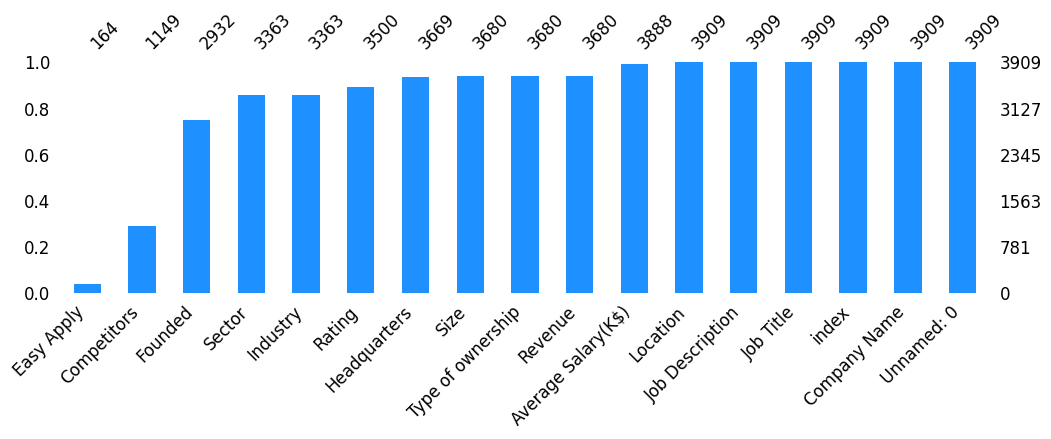

In [12]:
# Checking percentage of null values
print(df.isnull().mean() * 100)

# Visualize missing values using a bar chart
msno.bar(df, figsize=(12, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

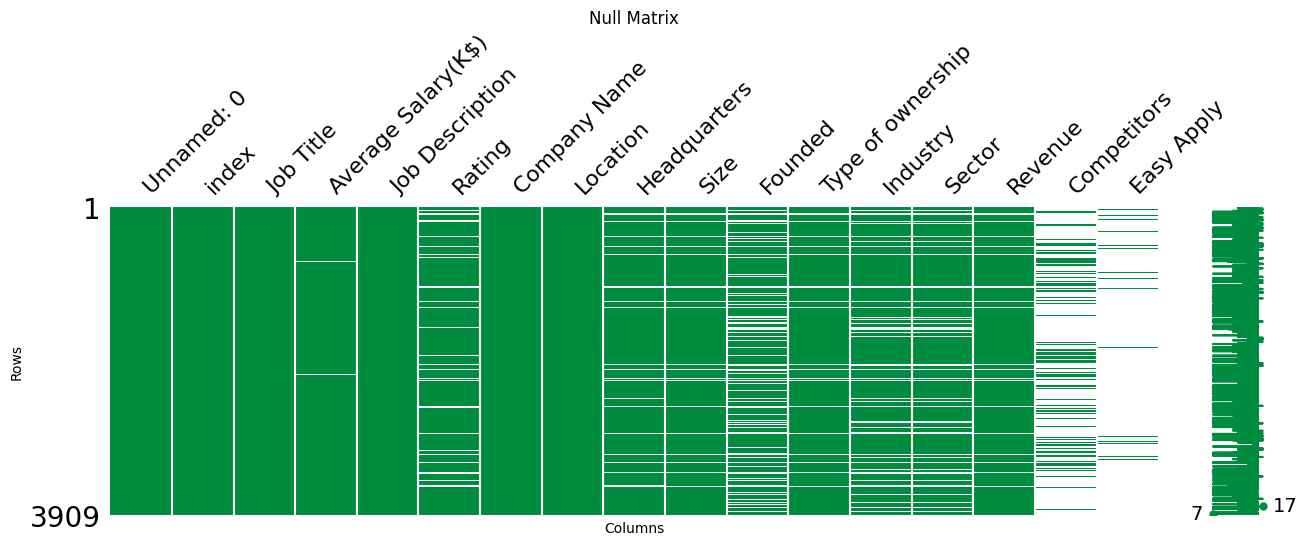

In [13]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df, figsize=(15, 4), color=(0, 0.55, 0.25))

# Set plot labels and title
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.title("Null Matrix")

# Show the plot
plt.show()

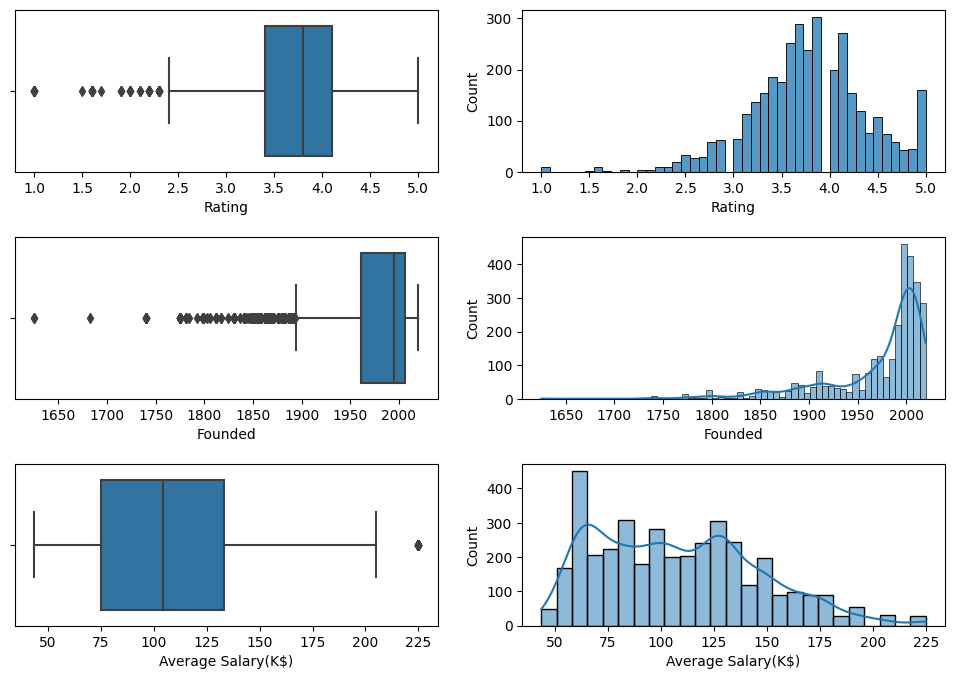

In [14]:
# Let's check if there are any outliers in the numerical columns
fig, ax = plt.subplots(3, 2, figsize=(12, 8))

sns.boxplot(x=df["Rating"], ax=ax[0][0])
sns.histplot(x=df["Rating"], ax=ax[0][1])

sns.boxplot(x=df["Founded"], ax=ax[1][0])
sns.histplot(data=df["Founded"], ax=ax[1][1], kde=True)

sns.boxplot(x=df["Average Salary(K$)"], ax=ax[2][0])
sns.histplot(data=df["Average Salary(K$)"], ax=ax[2][1], kde=True)

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

# Data Cleaning and processing

During the data cleaning and processing phase there are few steps which we need to perform with respect to this dataset and these steps are 👇

1. Removing unnecessary columns
2. Handling missing values
3. Handling ouliters outliers
4. Encoding the categorical values
5. Scaling the numerical features

In [15]:
# Dropping unnecessary features
df.drop(['Unnamed: 0','index','Job Description','Competitors', 'Easy Apply'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

For the complete data processing we will be creating a pipeline, but before making a pipeling we need to explore all the techniques which we can use to process and clean our data in most efficient way and for this we will simply create a copy of the dataframe.

In [16]:
train_data,test_data = train_test_split(df,train_size=0.8,shuffle=True)

# Creating a copy of the training dataframe
temp_df = train_data.copy()
temp_df.reset_index(drop=True,inplace=True)
temp_df.head(3)

,Job Title,Average Salary(K$),Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Post Doctoral Scientist Year 1 3 Research C/PM...,62.5,3.7,Nationwide Childrens Hospital,OH,OH,10000+ employees,1892.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$1 to $2 billion (USD)
1,Data Analyst,169.5,5.0,Whip Media Group,NY,CA,51 to 200 employees,2016.0,Company - Private,NaN,NaN,Unknown / Non-Applicable
2,"Data Scientist, FEAR",193.5,4.1,Apple,CA,CA,10000+ employees,1976.0,Company - Public,Computer Hardware & Software,Information Technology,$10+ billion (USD)


### Dealing with missing values

In order to deal with missing values we can either impute them or we can remove them. Generally for the features having percentage of missing values less than 5% it is safe to remove the missing values. But in order to retain as much data as possible we will compare the effect of both removing and imputing the missing values.

In [17]:
# Let's take out features having missing value percentage less than 5%
Less_10PER = [
    col
    for col in temp_df.columns
    if temp_df[col].isnull().mean() * 100 < 10 and temp_df[col].isnull().mean() * 100 > 0
]
print("Features having less than 10% Missing values are ",Less_10PER)

Features having less than 10% Missing values are  ['Average Salary(K$)', 'Headquarters', 'Size', 'Type of ownership', 'Revenue']


In [18]:
# Mode imputation
for cols in ['Headquarters', 'Size', 'Type of ownership','Revenue']:
    temp_df[cols].fillna(temp_df[cols].mode()[0],inplace=True)

# Mean imputation
temp_df['Average Salary(K$)'] = temp_df['Average Salary(K$)'].fillna(temp_df['Average Salary(K$)'].mean())

In [19]:
More_10PER = [
    col
    for col in temp_df.columns
    if temp_df[col].isnull().mean() * 100 < 50 and temp_df[col].isnull().mean() * 100 > 10
]
print("Features having more than 10% Missing values are ",More_10PER)

Features having more than 10% Missing values are  ['Rating', 'Founded', 'Industry', 'Sector']


For remaining columns having missing values more than 10% we will be using advance imputation technique like KNN imputer, but for using any advance imputation techniue we need to make sure our data is ready which means our data should be properly encoded for KNN  imputer and should also be free from the outliers, so before using the KNN imputer we will encode and deal with outliers and then we will use KNN imputer for imputing the missing values.

In [20]:
# Let's do target encoding of the Industry and Sector feature
target_enc = ce.TargetEncoder(smoothing=0.4, handle_missing="return_nan", return_df=False)

y = temp_df["Average Salary(K$)"].values.reshape(-1, 1)
	
for cols in ['Industry','Sector','Job Title','Type of ownership','Company Name','Location','Headquarters']:
    temp_df[cols] = pd.Series(target_enc.fit_transform(temp_df[cols].values.reshape(-1, 1), y).reshape(-1))

In [21]:
# Imputing values in the features having more than 10% Missing values
knn_imputer = KNNImputer(n_neighbors=5, metric="nan_euclidean")

temp_df[More_10PER] = knn_imputer.fit_transform(temp_df[More_10PER])

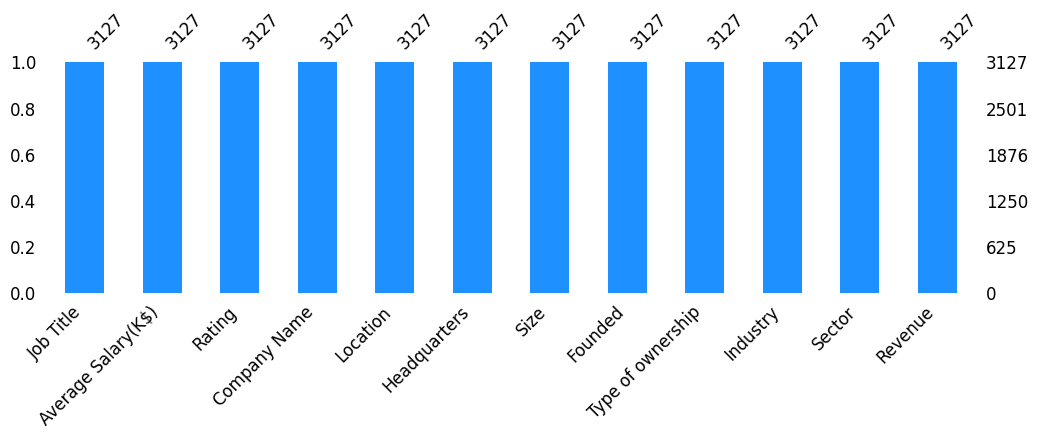

In [22]:
# Visualize missing values using a bar chart
msno.bar(temp_df, figsize=(12, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [23]:
# Let's do ordinal encoding 
revenue_options = ['Unknown / Non-Applicable', '$10+ billion (USD)','$100 to $500 million (USD)', '$50 to $100 million (USD)',
    '$2 to $5 billion (USD)', '$10 to $25 million (USD)','$1 to $5 million (USD)', '$1 to $2 billion (USD)',
    '$25 to $50 million (USD)', '$5 to $10 billion (USD)','Less than $1 million (USD)', '$500 million to $1 billion (USD)',
    '$5 to $10 million (USD)']

size_options = ['10000+ employees', '51 to 200 employees', '1 to 50 employees',
    '1001 to 5000 employees', '201 to 500 employees','501 to 1000 employees', '5001 to 10000 employees', 'Unknown']

oe_size = OrdinalEncoder(categories=[size_options],handle_unknown="use_encoded_value",unknown_value=np.nan)
oe_revenue = OrdinalEncoder(categories=[revenue_options],handle_unknown="use_encoded_value",unknown_value=np.nan)

temp_df['Size'] = oe_size.fit_transform(temp_df['Size'].values.reshape(-1,1)).reshape(-1)
temp_df['Revenue'] = oe_revenue.fit_transform(temp_df['Revenue'].values.reshape(-1,1)).reshape(-1)

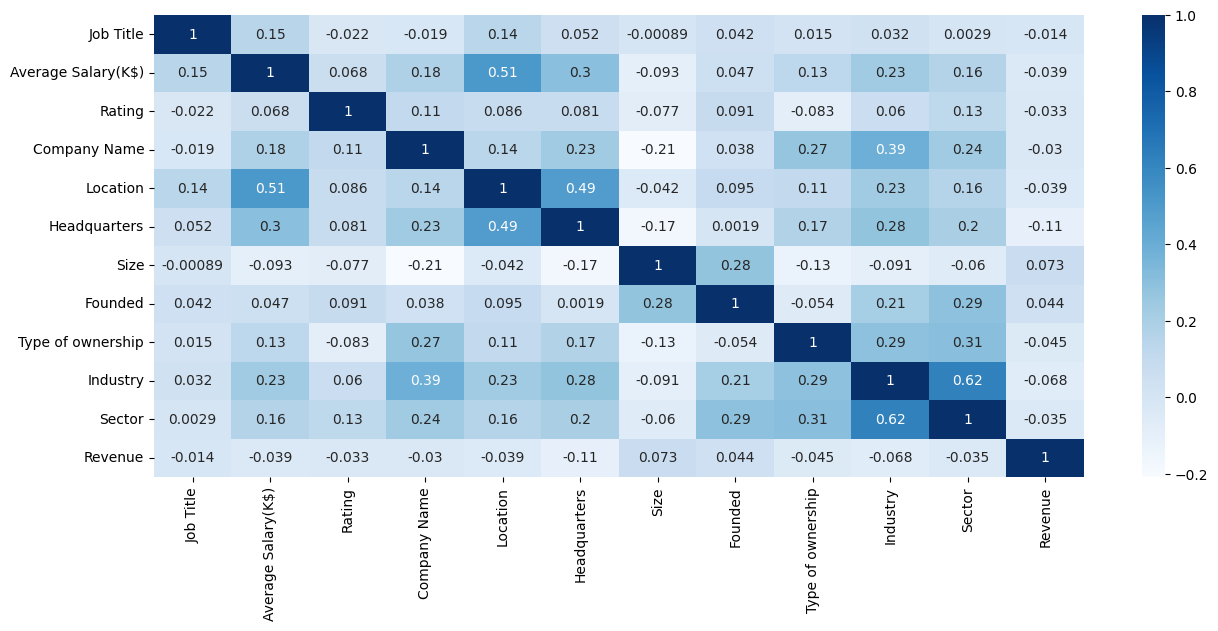

In [24]:
plt.figure(figsize=(15, 6))
sns.heatmap(temp_df.corr(), annot=True,cmap="Blues")
plt.show()

# Creation of Pipeline

As we have explored all the techniques which we will be using to deal with misssing values, outliers and cateogircal features. We will now create a pipeline that will do all the data cleaning and processing in a streamlined process.

- First we will create a column transformer to deal with missing values ( Simple imputtation techniques )
- Then we will create a column transformer for doing ordinal and target encoding
- After doing encoding we will use KNN imputer to impute the columns which were having high missing values percentage
- Followed by this we will scale our values
- Finally we will be using a machine learning model for training

**Down below is the descirption all the change in column positions after the data will go through each and every column transformer**

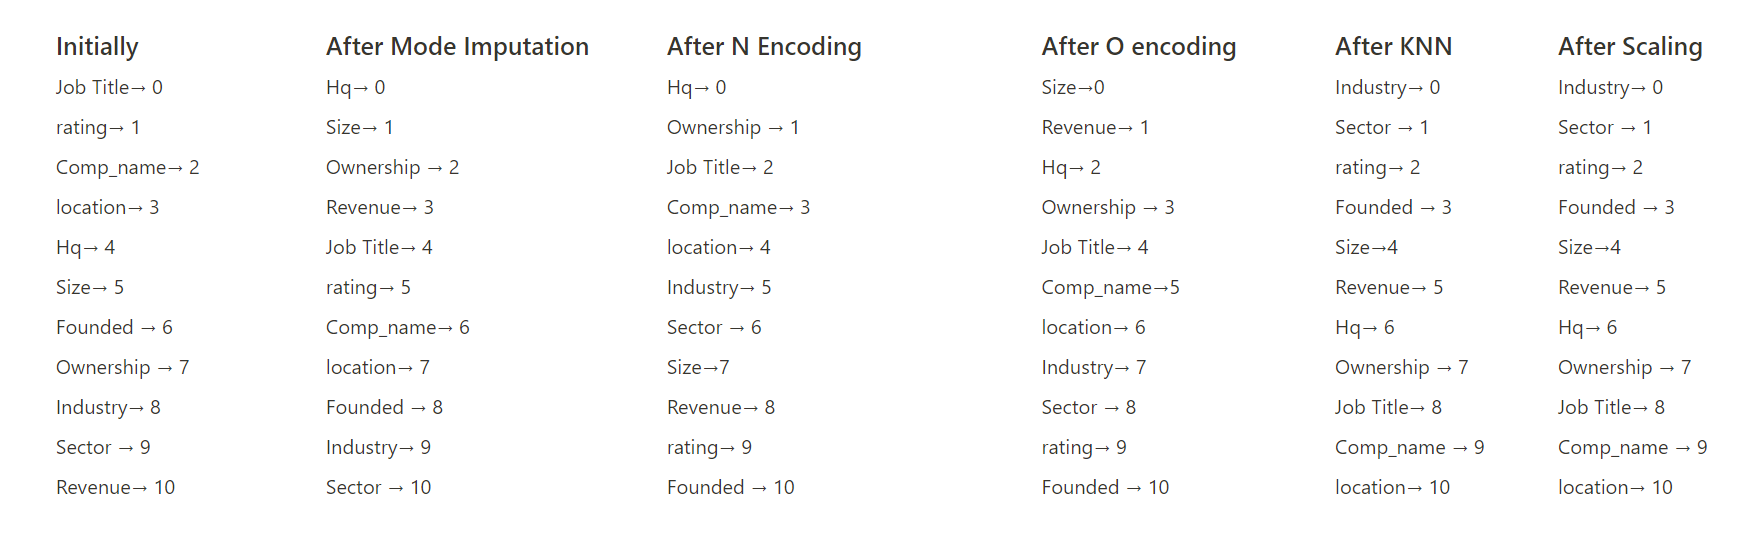

In [25]:
['Rating', 'Founded', 'Industry', 'Sector']

['Rating', 'Founded', 'Industry', 'Sector']

In [26]:
# Define the column transformer for imputation
Simple_impute_transformer = ColumnTransformer(
    transformers=[
        ("mode_imputer", SimpleImputer(strategy="most_frequent"), [4,5,7,10]),
    ],
    remainder="passthrough",
)

# Define the column transformer for encoding
nominal_encoding = ColumnTransformer(transformers=[
    ('Target_Encoding',ce.TargetEncoder(smoothing=0.4, handle_missing="return_nan", return_df=False),[0,2,4,6,7,9,10])
],remainder='passthrough')

ordinal_encoding = ColumnTransformer(transformers = [
    ('Ordinal_Encoding_size',OrdinalEncoder(categories=[size_options],handle_unknown="use_encoded_value",unknown_value=np.nan),[7]),
    ('Ordinal_Encoding_rev',OrdinalEncoder(categories=[revenue_options],handle_unknown="use_encoded_value",unknown_value=np.nan),[8])
],remainder='passthrough')


Knn_imputer = ColumnTransformer(
    transformers=[
        ("Knn_Imputer", KNNImputer(n_neighbors=5, metric="nan_euclidean"), [7,8,9,10])
    ],remainder="passthrough")


# Column transformer to do feature scaling
scaling_transformer = ColumnTransformer(
    transformers=[("scale_transformer", MinMaxScaler(), [0,1,2,3,4,5,6,7,8,9,10])], remainder="passthrough"
)


# Define the final pipeline
pipe = Pipeline(
    steps=[
        ("Mode_imputation", Simple_impute_transformer),
        ("Nominal_Encoding", nominal_encoding),
        ("Ordinal_Encoding", ordinal_encoding),
        ("Knn_imputer", Knn_imputer),
        ("Scaling", scaling_transformer)
    ]
)

In [27]:
# Seperating the data in dependent and independent
X_train = train_data.drop(['Average Salary(K$)'],axis=1)
y_train = train_data['Average Salary(K$)']

X_test = test_data.drop(['Average Salary(K$)'],axis=1)
y_test = test_data['Average Salary(K$)']

In [28]:
# Process the training and validation data
X_train = pipe.fit_transform(X_train, y_train)
X_test = pipe.transform(X_test)

## Dealing with imabalnced data

- Create validation data
- Check model performance on train data
- Keep dependent variable in and use the indexing

In [ ]:
X_train = pd.DataFrame(X_train)

# Balancing class imbalance
adasyn = ADASYN()
X_train, y_train = adasyn.fit_resample(X_train, y_train)

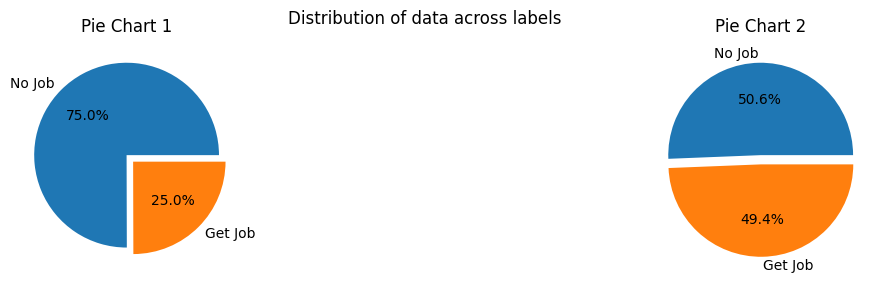

In [ ]:
# Let's compare the change in distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

ex = [0.0, 0.1]
ax[0].pie(
    df["target"].value_counts(),
    labels=["No Job", "Get Job"],
    autopct="%1.1f%%",
    explode=ex,
)
ax[0].set_title("Pie Chart 1")

ax[1].pie(
    y_train.value_counts(),
    labels=["No Job", "Get Job"],
    autopct="%1.1f%%",
    explode=ex,
)
ax[1].set_title("Pie Chart 2")

plt.suptitle("Distribution of data across labels")
plt.show()

In [ ]:
X_train = X_train.values
y_train = np.array(y_train.values)
y_test = np.array(y_test.values)

In [ ]:
X_train.shape

(22409, 9)

## Model comparision
For comparing the performance of various algorithms the setup method of pycaret expects

In [ ]:
input_data = df.drop(['target'],axis = 1)
output_data = df['target']

# Process the complete data
input_data = pipe.fit_transform(input_data,output_data)

# Balancing class imbalance
adasyn = ADASYN()
input_data, output_data = adasyn.fit_resample(input_data, output_data)

In [ ]:
pycaret_setup = setup(data=input_data, target=output_data.values, preprocess=False,train_size=0.8)

,Description,Value
0,Session id,1545
1,Target,target
2,Target type,Binary
3,Original data shape,"(27956, 10)"
4,Transformed data shape,"(27956, 10)"
5,Transformed train set shape,"(22364, 10)"
6,Transformed test set shape,"(5592, 10)"
7,Numeric features,9


In [ ]:
# All the models
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
# Let's get the best model
best_model = compare_models(fold=4, cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8427,0.9129,0.8528,0.8326,0.8426,0.6855,0.6857,0.4175
et,Extra Trees Classifier,0.8292,0.8889,0.8377,0.8201,0.8288,0.6585,0.6587,0.8450
rf,Random Forest Classifier,0.8283,0.8993,0.8256,0.8264,0.8260,0.6566,0.6567,0.7650
gbc,Gradient Boosting Classifier,0.7997,0.8679,0.7968,0.7972,0.7970,0.5994,0.5994,1.1000
dt,Decision Tree Classifier,0.7623,0.7635,0.7611,0.7582,0.7596,0.5246,0.5247,1.2675
ada,Ada Boost Classifier,0.7608,0.8210,0.7403,0.7668,0.7533,0.5213,0.5216,0.5950
knn,K Neighbors Classifier,0.7352,0.7960,0.8497,0.6875,0.7600,0.4719,0.4852,1.5425
qda,Quadratic Discriminant Analysis,0.6620,0.7012,0.6184,0.6708,0.6436,0.3231,0.3241,0.2725
nb,Naive Bayes,0.6575,0.6907,0.6214,0.6633,0.6417,0.3143,0.3149,1.2275
lda,Linear Discriminant Analysis,0.6525,0.6831,0.5754,0.6729,0.6203,0.3035,0.3067,0.2800


In [ ]:
# Let's evaluate the best model
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Model training and evaluation

In [ ]:
# Let's get the model hyper-parameters
print("Hyper-parameters:",best_model.get_params())

Hyper-parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 1545, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [ ]:
model = lgbm.LGBMClassifier()

# Let's train the model
model.fit(X_train, y_train)

# Model predictions
y_pred = model.predict(X_test)

## Model evlauation

In [ ]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculating precision
precision = precision_score(y_test, y_pred, average="macro")
print("Precision: ", precision)

# Calculating recall
recall = recall_score(y_test, y_pred, average="macro")
print("Recall: ", recall)

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average="macro")
print("F1 Score: ", f1)

Accuracy:  0.6751457339692634
Precision:  0.659987477578096
Recall:  0.7085599364677854
F1 Score:  0.6484494596198785


In [ ]:
Accuracy:  0.7782781456953642
Precision:  0.7130340468080059
Recall:  0.7325802989934873
F1 Score:  0.7210375644780725

![image.png](attachment:71b0a2da-2b97-45b7-b588-16cbd15f0838.png)

![image.png](attachment:db9d98d4-da7e-4fa5-8503-f4cf9d4770a9.png)

![image.png](attachment:dce7fb88-c77c-4990-9928-cffe55940599.png)

![image.png](attachment:bc8f5736-395c-4dfd-8253-443417ca1aa4.png)

In [ ]:
Accuracy:  0.8710470836261419
Precision:  0.8742822244618302
Recall:  0.8712109314811961
F1 Score:  0.8708018217937394

In [ ]:
# Saving model and pickle file
pickle.dump(df, open("df.pkl", "wb"))
pickle.dump(pipe, open("pipe.pkl", "wb"))

### Comparing multiple models

In [ ]:
# Get the list of available models
all_models = models()

# Print the list of models
models().index.values

array(['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge',
       'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'lightgbm', 'dummy'],
      dtype=object)

In [ ]:
# initialize setup with preprocessing
clf = setup(data, target=y_train, preprocess=False, use_gpu=True)

# compare selected models
best_model = compare_models(
    include=[
        "lr",
        "knn",
        "nb",
        "dt",
        "svm",
        "rbfsvm",
        "gpc",
        "mlp",
        "ridge",
        "rf",
        "qda",
        "ada",
        "gbc",
        "lda",
        "et",
        "lightgbm",
        "dummy",
    ]
)

,Description,Value
0,Session id,5513
1,Target,target
2,Target type,Binary
3,Original data shape,"(17076, 11)"
4,Transformed data shape,"(17076, 11)"
5,Transformed train set shape,"(11953, 11)"
6,Transformed test set shape,"(5123, 11)"
7,Categorical features,10


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8375,0.8992,0.8715,0.8163,0.8429,0.6751,0.6767,2.2080
et,Extra Trees Classifier,0.8269,0.9074,0.8485,0.8136,0.8306,0.6538,0.6545,1.7160
lightgbm,Light Gradient Boosting Machine,0.8012,0.8529,0.8133,0.7944,0.8036,0.6024,0.6028,3.5810
dt,Decision Tree Classifier,0.7775,0.7795,0.8404,0.7466,0.7907,0.5549,0.5595,0.4610
gbc,Gradient Boosting Classifier,0.7560,0.7993,0.7339,0.7681,0.7506,0.5121,0.5127,2.0740
ada,Ada Boost Classifier,0.7477,0.7889,0.7020,0.7729,0.7356,0.4954,0.4976,1.2750
knn,K Neighbors Classifier,0.7210,0.7746,0.7605,0.7051,0.7317,0.4420,0.4435,1.1220
gpc,Gaussian Process Classifier,0.7139,0.7660,0.7086,0.7167,0.7125,0.4278,0.4279,197.0630
mlp,MLP Classifier,0.7112,0.7681,0.7026,0.7169,0.7087,0.4224,0.4236,15.8810
rbfsvm,SVM - Radial Kernel,0.6935,0.7451,0.6717,0.7028,0.6867,0.3871,0.3876,44.5920


Since we can clearly see that random forest classifier is performing the best so we will use this algorithm.